In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast, math 
from scipy.signal import find_peaks, butter, lfilter, hilbert,filtfilt
import statistics 
from sympy import fft 
from IPython.core.debugger import set_trace
import pywt
pd.options.mode.chained_assignment = None  # default='warn'
import sys
import pickle
import shelve
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

In [2]:
path = 'C:/Users/mpitarke/Dropbox (MGEP)/PC/Documents/MASTER/Files/';

with open(path+'data_100.pickle', 'rb') as data_100_sv:
    data_100 = pickle.load(data_100_sv);
    
data_100_sv.close();
    
with open(path+'Y.pickle', 'rb') as Y_sv:
    Y = pickle.load(Y_sv);

Y_sv.close();

with open(path+'Y_final.pickle', 'rb') as Y_final_sv:
    Y_final = pickle.load(Y_final_sv);
    
Y_final_sv.close();
    
with open(path+'data_100_upd.pickle', 'rb') as data_100_upd_sv:
    data_100_upd = pickle.load(data_100_upd_sv);
    
data_100_upd_sv.close();

with open(path+'data_100_upd_I_lead.pickle', 'rb') as data_100_upd_I_lead_sv:
    data_100_upd_I_lead = pickle.load(data_100_upd_I_lead_sv);

data_100_upd_I_lead_sv.close();

**SUPERCLASS DISTRIBUTION**

In [3]:
Y_final.head(1)

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   

       baseline_drift static_noise burst_noise electrodes_problems  \
ecg_id                                                               
1                 NaN    , I-V1,           NaN                 NaN   

        extra_beats  pacemaker  strat_fold                filename_lr  \
ecg_id                                                                  
1               NaN        NaN           3  records100/00000/00001_lr   

                      filename_hr diagnostic_superclass  
ecg_id                                                   
1       records500/00000/00001_hr                [NORM]  

[1 rows x 28 columns]

In [4]:
Y_final['diagnostic_superclass'].iloc[0]

['NORM']

In [5]:
index = [];
for i in np.arange(len(Y_final['diagnostic_superclass'])):
    if np.size(Y_final['diagnostic_superclass'].iloc[i])>=2:
        index.append(i);
        
print(index)

[8630]


In [6]:
Y_final['diagnostic_superclass'].iloc[8630]

['HYP', 'STTC']

In [7]:
Y_final.iloc[8630]

patient_id                                                                 2353.0
age                                                                          77.0
sex                                                                             1
height                                                                        NaN
weight                                                                        NaN
nurse                                                                         NaN
site                                                                          5.0
device                                                                 AT-6 C 5.5
recording_date                                                1992-08-10 13:39:56
report                          sinus tachycardia. atrial premature contractio...
scp_codes                       {'LVH': 35.0, 'LAO/LAE': 50.0, 'PVC': 100.0, '...
heart_axis                                                                    NaN
infarction_stadi

In [8]:
Y_final['diagnostic_superclass'][8746]

['HYP', 'STTC']

In [9]:
Y_final['diagnostic_superclass'].iloc[8630] = ['HYP'];

In [10]:
Y_final['diagnostic_superclass'][8746]

['HYP']

In [11]:
Y_final['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21430, dtype: object

In [12]:
np.size(Y_final['diagnostic_superclass'].iloc[0])

1

In [13]:
# In order to remove the signals that have not a professional diagnosis:

index = [];
for i in np.arange(len(Y_final['diagnostic_superclass'])):
    if np.size(Y_final['diagnostic_superclass'].iloc[i])==0:
        print(i)
        index.append(i);
        
print(index)

[]


In [14]:
Y_final['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21430, dtype: object

In [15]:
np.concatenate(Y_final['diagnostic_superclass'].values)

array(['NORM', 'NORM', 'NORM', ..., 'STTC', 'NORM', 'NORM'], dtype='<U4')

In [16]:
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))
superclass_cols = all_superclass.unique()
superclass_cols = all_superclass.unique()
meta_cols = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device',] # could add more columns as features

In [17]:
meta_cols

['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device']

**Meaning of Superclassses** 

**NORM:** Normal ECG  
**MI:** Myocardial Infarction, a myocardial infarction (MI), commonly known as a heart attack, occurs when blood flow decreases or stops to a part of the heart, causing damage to the heart muscle Reference  
**STTC:** ST/T Change, ST and T wave changes may represent cardiac pathology or be a normal variant. Interpretation of the findings, therefore, depends on the clinical context and presence of similar findings on prior electrocardiograms.  
**CD:** Conduction Disturbance. Your heart rhythm is the way your heart beats. Conduction is how electrical impulses travel through your heart, which causes it to beat. Some conduction disorders can cause arrhythmias, or irregular heartbeats.  
**HYP:** Hypertrophy, Hypertrophic cardiomyopathy (HCM) is a disease in which the heart muscle becomes abnormally thick (hypertrophied). The thickened heart muscle can make it harder for the heart to pump blood.  

In [18]:
superclass_cols

array(['NORM', 'MI', 'STTC', 'HYP', 'CD'], dtype=object)

In [19]:
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
            
        return row

In [20]:
def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = x[filt]
    y_selected = y[filt]
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]

In [21]:
X = data_100_upd_I_lead;

In [22]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y_final, superclass_cols, meta_cols);
print(y_all)

         age  sex  height  weight  nurse  site      device  NORM  MI  STTC  \
ecg_id                                                                       
1       56.0    1     NaN    63.0    2.0   0.0   CS-12   E     1   0     0   
2       19.0    0     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
3       37.0    1     NaN    69.0    2.0   0.0   CS-12   E     1   0     0   
4       24.0    0     NaN    82.0    2.0   0.0   CS-12   E     1   0     0   
5       19.0    1     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
...      ...  ...     ...     ...    ...   ...         ...   ...  ..   ...   
21833   67.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0     1   
21834   93.0    0     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   
21835   59.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0     1   
21836   64.0    1     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   
21837   68.0    0     NaN     NaN    1.0   2.0  AT-60    3     1

In [23]:
y_all.head(5)

age  sex  height  weight  nurse  site     device  NORM  MI  STTC  \
ecg_id                                                                      
1       56.0    1     NaN    63.0    2.0   0.0  CS-12   E     1   0     0   
2       19.0    0     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   
3       37.0    1     NaN    69.0    2.0   0.0  CS-12   E     1   0     0   
4       24.0    0     NaN    82.0    2.0   0.0  CS-12   E     1   0     0   
5       19.0    1     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   

        HYP  CD  strat_fold  
ecg_id                       
1         0   0           3  
2         0   0           2  
3         0   0           5  
4         0   0           3  
5         0   0           4

> Converting Categorical Variables (Device variable) into Dummy Variables which is an essential part of data pre-processing, 
which in itself is an integral part of the Machine Learning or Statistical Model.   

> Dummy Variables act as indicators of the presence or absence of a category in a Categorical Variable.   
> The usual convention dictates that 0 represents absence while 1 represents presence.   
> The conversion of Categorical Variables into Dummy Variables leads to the formation of the two-dimensional binary matrix 
where each column represents a particular category.

In [24]:
x_all[0:6]

array([[-0.119, -0.116, -0.12 , ...,  0.069,  0.086,  0.022],
       [ 0.004, -0.02 , -0.053, ...,  0.121, -0.326, -0.348],
       [-0.029, -0.035, -0.054, ..., -0.029, -0.048, -0.049],
       [-0.054, -0.053, -0.063, ...,  0.026,  0.026,  0.028],
       [-0.034, -0.038, -0.057, ...,  0.   , -0.003, -0.012],
       [-0.032, -0.018,  0.02 , ..., -0.159, -0.206, -0.419]])

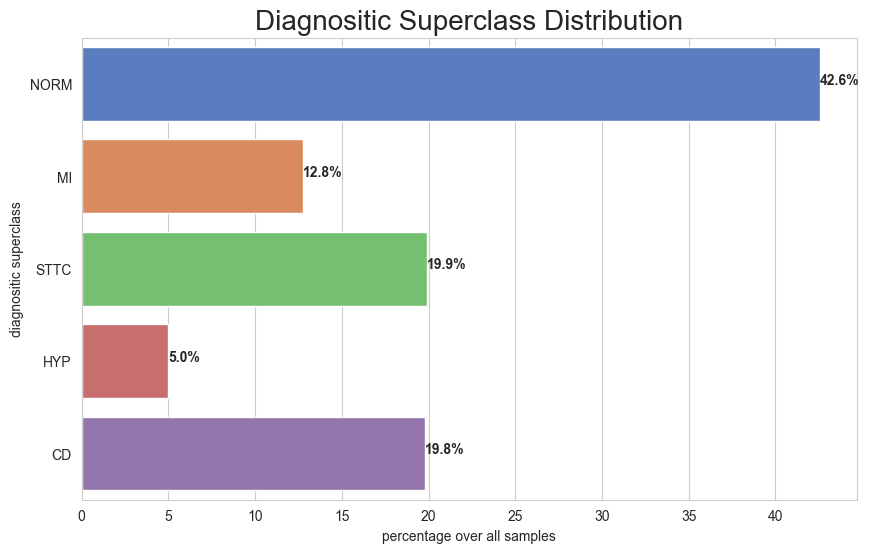

In [68]:
vc = y_all[superclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Superclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic superclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

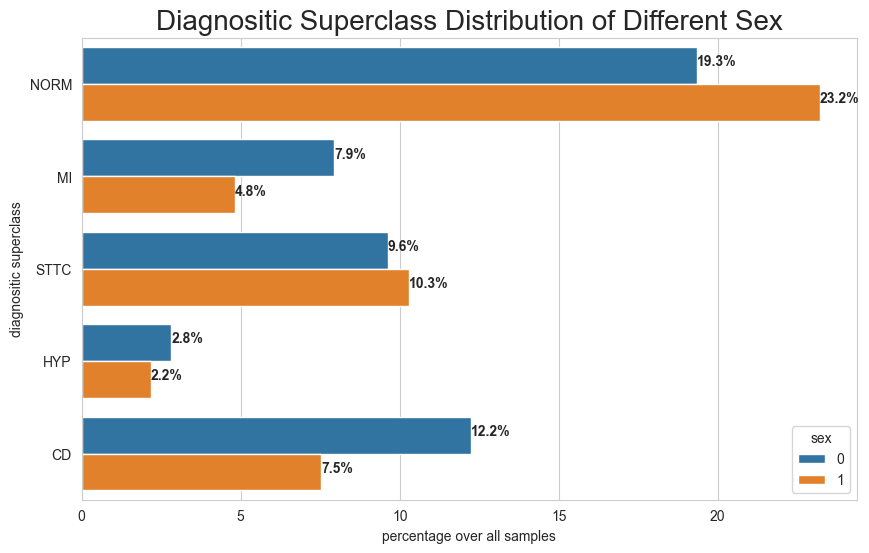

In [59]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
    
ax.set_title("Diagnositic Superclass Distribution of Different Sex", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_all.sex.unique():
    vc = y_all.loc[y_all.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['sex'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

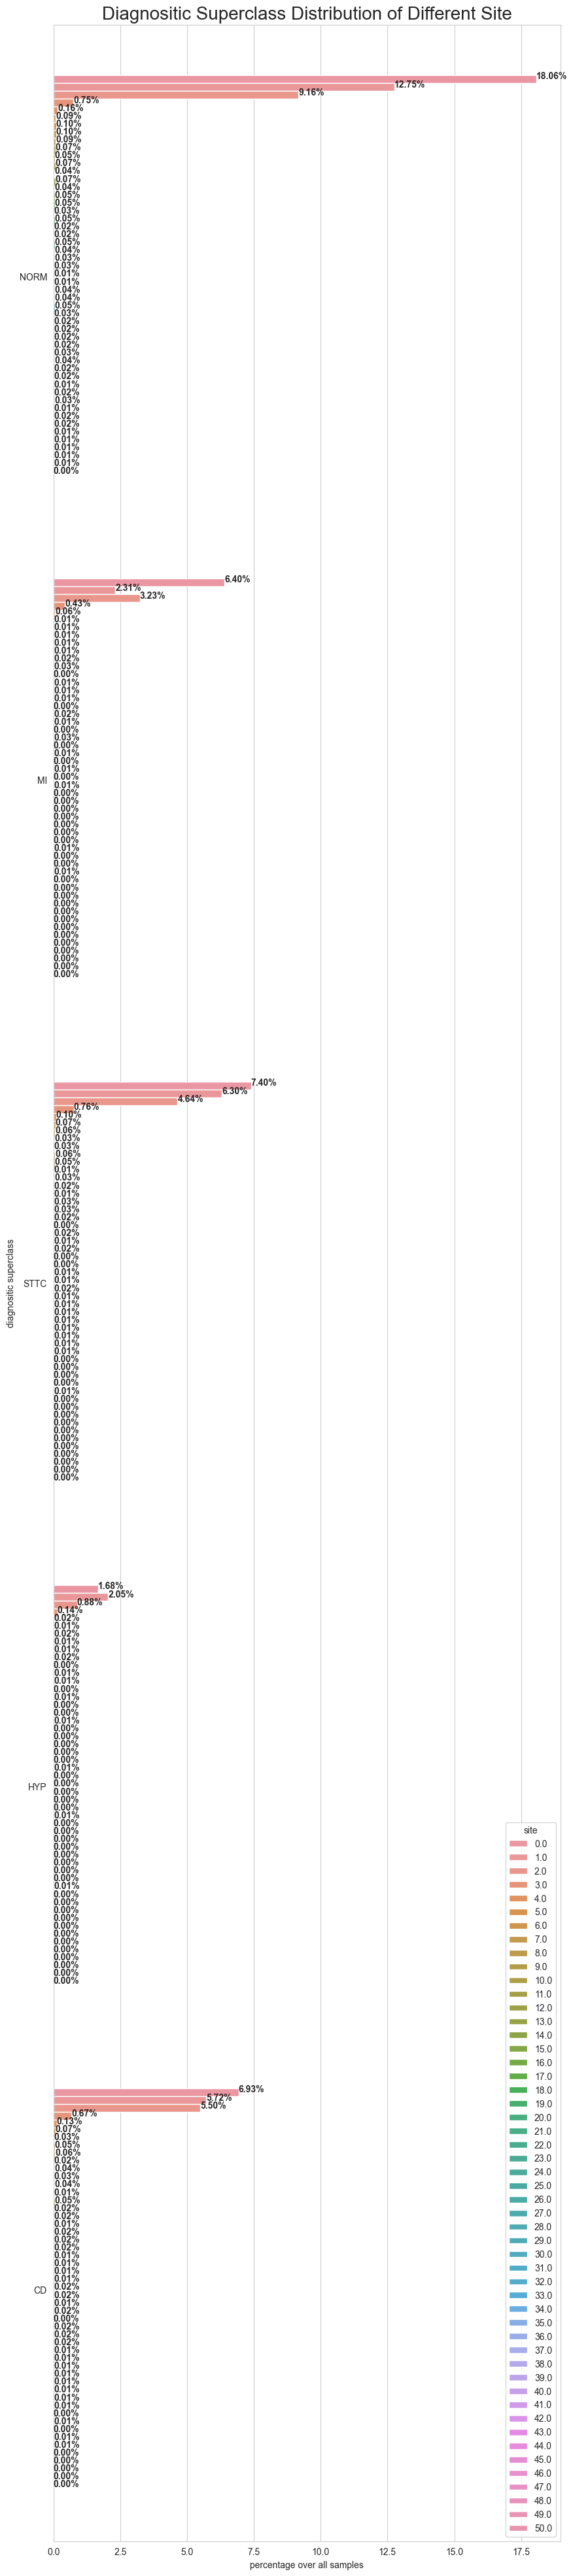

In [85]:
# NOT USEFUL

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,50))
    
ax.set_title("Diagnositic Superclass Distribution of Different Site", fontsize=20)

all_index, all_count, all_values = [], [], []
for site in y_all.site.unique():
    vc = y_all.loc[y_all.site == site][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [site]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['site'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="site",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

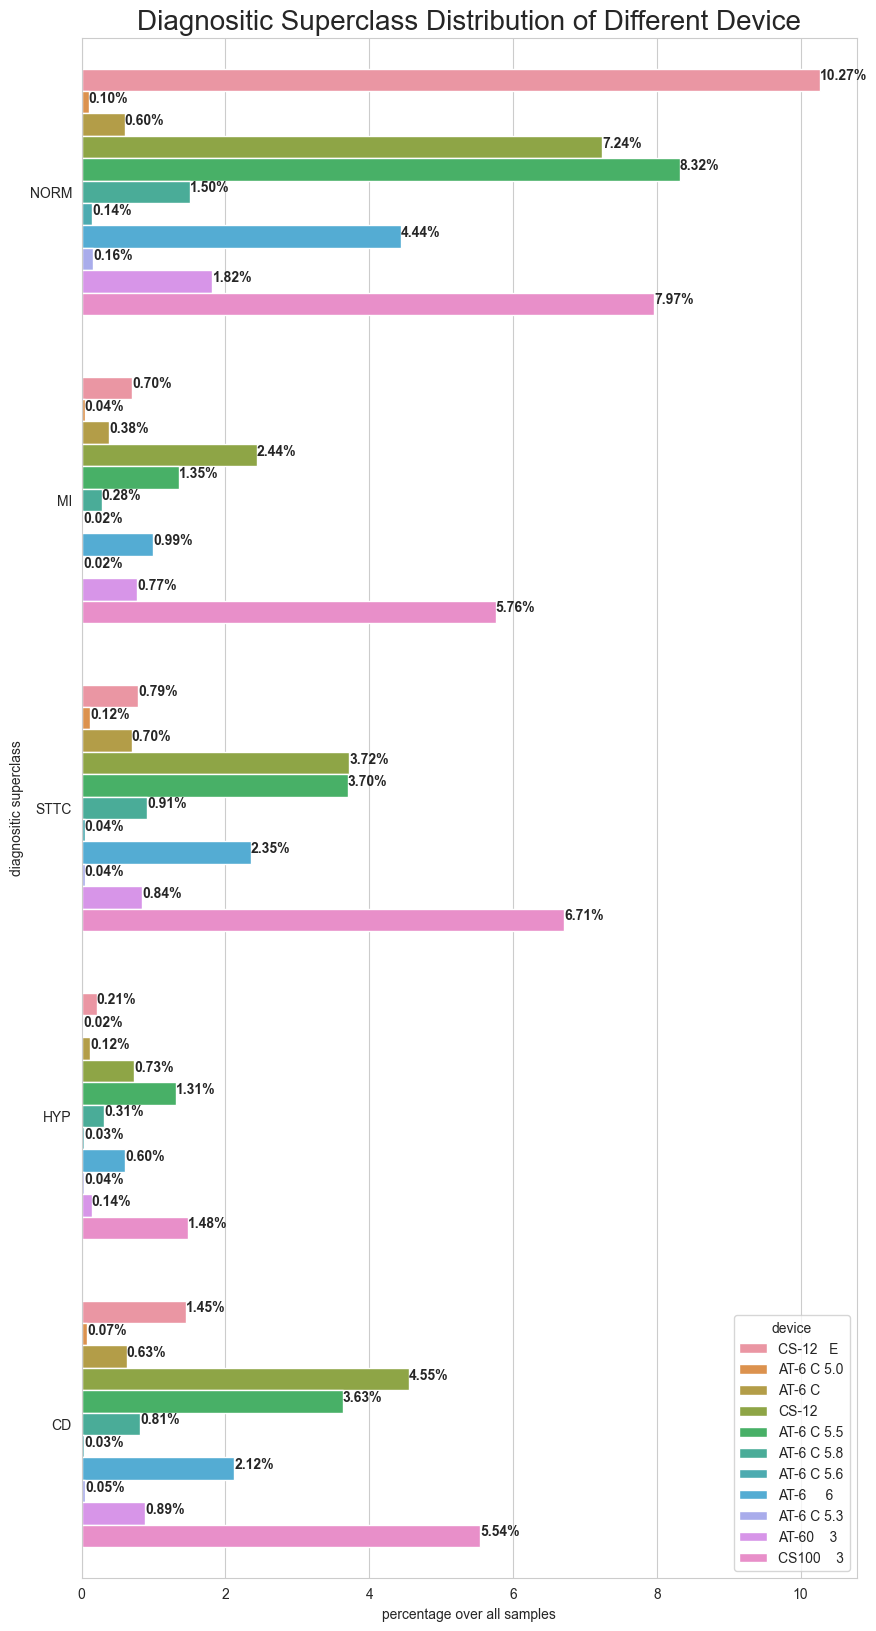

In [96]:
# NOT USEFUL

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Diagnositic Superclass Distribution of Different Device", fontsize=20)

all_index, all_count, all_values = [], [], []
for device in y_all.device.unique():
    vc = y_all.loc[y_all.device == device][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [device]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['device'] = all_values

ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="device",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

> Vamos a analizar los conocidos **missing values**:

In [25]:
def missing_values(df):
    missing_variables = []
    df_aux = df.isna()
    var = []
    for f in df.columns:
        missings_rows = df_aux[df_aux[f] == True][f].count()
        if missings_rows > 0:
            missing_variables.append(f)
            missings_perc = missings_rows/df.shape[0]
            print('La variable {} tiene {} registro/s ({:.2%}) con valores nulos'.format(f, missings_rows, missings_perc))
            var.append(f)
    return var

In [26]:
var_y_all = missing_values(y_all)

La variable age tiene 85 registro/s (0.40%) con valores nulos
La variable height tiene 14503 registro/s (67.68%) con valores nulos
La variable weight tiene 12056 registro/s (56.26%) con valores nulos
La variable nurse tiene 1479 registro/s (6.90%) con valores nulos
La variable site tiene 17 registro/s (0.08%) con valores nulos


In [27]:
y_all.isnull().sum()

age              85
sex               0
height        14503
weight        12056
nurse          1479
site             17
device            0
NORM              0
MI                0
STTC              0
HYP               0
CD                0
strat_fold        0
dtype: int64

In [28]:
y_all['site'].unique()

array([ 0.,  3.,  2.,  1., 35., 16.,  4., 39., 32., 17.,  9., 10., 34.,
       44., 11., 30., 36., 13.,  5., 12., 38., 15., 25.,  8., 14., 20.,
       29., 24., 21., 26.,  6., 22., 18., 28., 45., 41., 49., 40., 37.,
       27., 43.,  7., 19., 48., 42., 33., 23., nan, 46., 50., 47., 31.])

No tendremos en cuenta ni la altura, ni el peso ya que el porcentaje de valores nulos es extremadamente alto, y es díficil predecir o sustituir esos valores sin afectar a los modelos que se crearán a continuación. Tampoco tendremos en cuenta la edad, ni la enfermera ni site, ya que es información inrrelevante para la tarea que tenemos como objetivo. 

In [29]:
y_all.head(10)

age  sex  height  weight  nurse  site     device  NORM  MI  STTC  \
ecg_id                                                                      
1       56.0    1     NaN    63.0    2.0   0.0  CS-12   E     1   0     0   
2       19.0    0     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   
3       37.0    1     NaN    69.0    2.0   0.0  CS-12   E     1   0     0   
4       24.0    0     NaN    82.0    2.0   0.0  CS-12   E     1   0     0   
5       19.0    1     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   
6       18.0    1     NaN    58.0    2.0   0.0  CS-12   E     1   0     0   
7       54.0    0     NaN    83.0    2.0   0.0  CS-12   E     1   0     0   
8       48.0    0     NaN    95.0    2.0   0.0  CS-12   E     0   1     0   
9       55.0    0     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   
10      22.0    1     NaN    56.0    2.0   0.0  CS-12   E     1   0     0   

        HYP  CD  strat_fold  
ecg_id                       
1         0   0           3  
2         0   0           2  
3         0   0           5  
4         0   0           3  
5         0   0           4  
6         0   0           4  
7         0   0           7  
8         0   0           9  
9         0   0          10  
10        0   0           9

In [79]:
y_all['age'].dtype

dtype('float64')

In [80]:
y_all.columns

Index(['age', 'sex', 'height', 'weight', 'nurse', 'site', 'NORM', 'MI', 'STTC',
       'HYP', 'CD', 'strat_fold', 'device_AT-6     6', 'device_AT-6 C',
       'device_AT-6 C 5.0', 'device_AT-6 C 5.3', 'device_AT-6 C 5.5',
       'device_AT-6 C 5.6', 'device_AT-6 C 5.8', 'device_AT-60    3',
       'device_CS-12', 'device_CS-12   E', 'device_CS100    3'],
      dtype='object')

In [83]:
# NO USAMOS FINALMENTE - Era una manera de predecir valores faltantes/nulos
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

def predicting_missing_values (variable, dataframe):

    data_with_null = dataframe[[variable, 'age', 'sex', 'nurse', 'device_AT-6 C', 'device_AT-6     6', 'device_AT-6 C 5.0', 
                            'device_AT-6 C 5.3', 'device_AT-6 C 5.5', 'device_AT-6 C 5.6', 'device_AT-6 C 5.8', 
                            'device_AT-60    3', 'device_CS-12', 'device_CS-12   E', 'device_CS100    3']];

    data_without_null = data_with_null.dropna();

    # All features except AGE
    train_data_x = data_without_null.iloc[:,1:15];

    #Only AGE
    train_data_y = data_without_null.iloc[:,0];

    # Training data
    linreg.fit(train_data_x, train_data_y)

    # Predicting values
    test_data = data_with_null.iloc[:,1:15];
    age_predicted = pd.Series(np.round(linreg.predict(test_data)))

    # Replacing missing values
    data_with_null.site.fillna(age_predicted, inplace=True)
    
    return data_with_null


In [84]:
data_with_null = predicting_missing_values ('site', y_all)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [459]:
data_with_null.isnull().sum()

site                 0
age                  0
sex                  0
nurse                0
device_AT-6 C        0
device_AT-6     6    0
device_AT-6 C 5.0    0
device_AT-6 C 5.3    0
device_AT-6 C 5.5    0
device_AT-6 C 5.6    0
device_AT-6 C 5.8    0
device_AT-60    3    0
device_CS-12         0
device_CS-12   E     0
device_CS100    3    0
dtype: int64

In [103]:
y_all.columns

Index(['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'NORM',
       'MI', 'STTC', 'HYP', 'CD', 'strat_fold'],
      dtype='object')

In [30]:
y_all = y_all.drop(['age', 'height', 'weight', 'nurse', 'site', 'device'], axis=1)
y_all.columns

Index(['sex', 'NORM', 'MI', 'STTC', 'HYP', 'CD', 'strat_fold'], dtype='object')

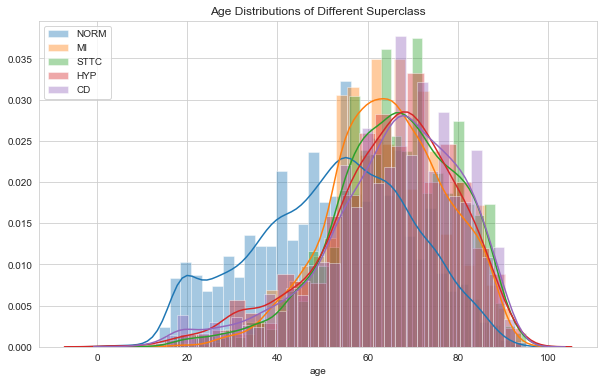

In [465]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Age Distributions of Different Superclass')

for superclass in superclass_cols:
    data = y_all.loc[y_all[superclass] == 1]['age']   
    sns.distplot(data, label=superclass)


plt.legend(loc='upper left')
plt.show()

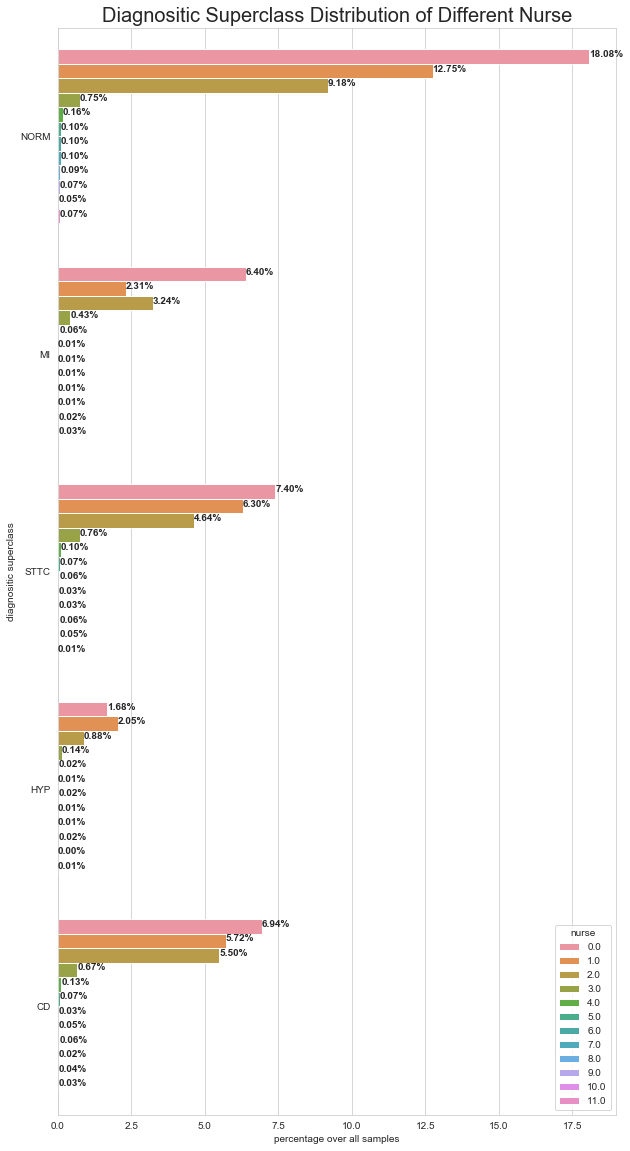

In [474]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Diagnositic Superclass Distribution of Different Nurse", fontsize=20)

all_index, all_count, all_values = [], [], []
for nurse in y_all.nurse.unique():
    vc = y_all.loc[y_all.site == nurse][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [nurse]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['nurse'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="nurse",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

In [31]:
y_all.head(5)

sex  NORM  MI  STTC  HYP  CD  strat_fold
ecg_id                                          
1         1     1   0     0    0   0           3
2         0     1   0     0    0   0           2
3         1     1   0     0    0   0           5
4         0     1   0     0    0   0           3
5         1     1   0     0    0   0           4

In [32]:
def transform_float_int(df):
    var = df.columns
    for variant in var:
        if df[variant].dtype == 'float64':
            df[variant] = df[variant].astype('int64')
    return df

In [33]:
y_all = transform_float_int(y_all)
y_all.head(5)

sex  NORM  MI  STTC  HYP  CD  strat_fold
ecg_id                                          
1         1     1   0     0    0   0           3
2         0     1   0     0    0   0           2
3         1     1   0     0    0   0           5
4         0     1   0     0    0   0           3
5         1     1   0     0    0   0           4

In [479]:
# EDA anterior
np.savetxt(path+"y_all_for_graphs.csv", y_all, delimiter=",")

In [34]:
y_all.columns

Index(['sex', 'NORM', 'MI', 'STTC', 'HYP', 'CD', 'strat_fold'], dtype='object')

In [35]:
y_all = y_all.drop(['NORM', 'MI', 'STTC', 'HYP', 'CD'], axis=1)
y_all.columns

Index(['sex', 'strat_fold'], dtype='object')

In [36]:
y_all['sex']

ecg_id
1        1
2        0
3        1
4        0
5        1
        ..
21833    1
21834    0
21835    1
21836    1
21837    0
Name: sex, Length: 21430, dtype: int64

In [37]:
with open(path+'y_all.pickle', 'wb') as y_all_sv:
    pickle.dump(y_all, y_all_sv);
y_all_sv.close();